In [1]:
# !pip install umap-learn

In [2]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [3]:
dataset = datasets.load_dataset('bookcorpus')['train']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [4]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15
subpath = '20240711.03:00:33' # all1_layerNorm
subpath = '20240711.03:33:04' # all1_layerNorm, lr 2e-5
subpath = '20240711.03:33:24' # all1_layerNorm, lr 5e-6
subpath = '20240711.03:48:45' # all1_layerNorm, lr 1e-6
subpath = '20240711.15:40:27' # bookcorpus, lr 4e-5
subpath = '20240711.16:14:06' # multi granularity, bookcorpus, lr 4e-5
subpath = '20240711.17:23:01' # log_granularity [1,2,2,3,5,5,6,6], bookcorpus, lr 4e-5

weight norms, min: 0.10725504159927368, max: 0.7680855989456177
min norms: ['[PAD]', 'gambling', 'benedict', 'mummy', 'mimi', 'mechanism', 'sterile', 'bonfire', 'processing', 'archibald']
max norms: ['her', 'in', 'it', 'me', 'was', "'", 'to', 'the', 'and', ',']
bias norms, min: -0.07141588628292084, max: 0.07863214612007141
min norms: ['[PAD]', 'ʼ', 'अ', 'ђ', '##真', '##ර', 'racecourse', '1663', 'ɣ', 'depicts']
max norms: ['her', 'a', 'it', 'me', "'", 'to', 'and', 'the', '.', ',']


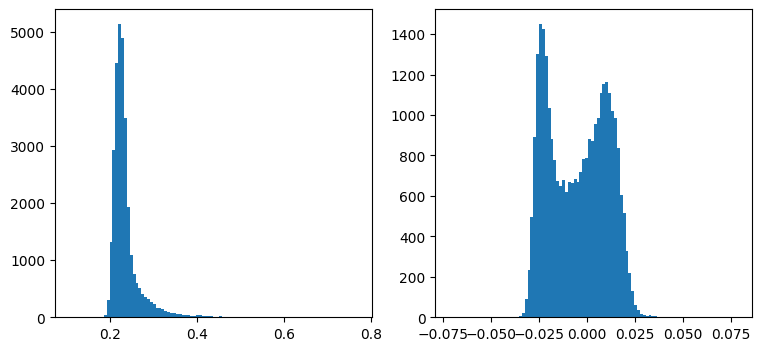

In [5]:
epoch_num = 0
batch_num = 50000


folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [6]:
# %%time
from collections import defaultdict

def get_projection(representations, n_neighbors=10, methods=['euclidean', 'cosine'], n_jobs=16):
  transed_repr = {}
  for method in methods:
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric=method, n_jobs=n_jobs)
    transed_repr[method] = reducer.fit_transform(representations)
  return transed_repr

def grouped_get_projection(representations_dict_groupNames, **kwargs):
  
  size_repr_len_pairs = [[name, reprs, reprs.shape[0]] for name, reprs in representations_dict_groupNames.items()]
  names, reprs, lengths = [*zip(*size_repr_len_pairs)]

  transeds = get_projection(torch.cat(reprs))
  to_return = defaultdict(defaultdict)
  for method, transed in transeds.items():
    accum_length = 0
    for name, length in zip(names, lengths):
      to_return[method][name] = transed[accum_length:accum_length+length]
      accum_length += length
    
  return to_return
  

pivot = torch.zeros(1, word_reprs.shape[1])
pivot[0, 0] = 1
origin = torch.zeros(1, word_reprs.shape[1])

transeds_dict_methods_groupNames = grouped_get_projection({'word': word_reprs, 'pivot': pivot, 'origin': origin})

# transeds_dict_methods = get_projection(torch.cat([word_reprs, pivot]))
# transed_words_dict_methods = {name: transed[:-1] for name, transed in transeds_dict_methods.items()} #transed word representations in a dict with methods as keys
# transed_pivots_dict_methods = {name: transed[-1:] for name, transed in transeds_dict_methods.items()}
vector_norms = np.linalg.norm(word_reprs, axis=1)
# del model

In [7]:
from utils.inspecting import inspect_direction_representing_words

def draw_and_annotate(ax, points, word_pos_pairs):
  image = ax.scatter(*points.T, marker='.', edgecolors='none', cmap=cmap, c=norms, alpha=.2, vmin=0)

  for word, x_y in word_pos_pairs:
    ax.annotate(word, x_y, alpha=.7)

0.03952284

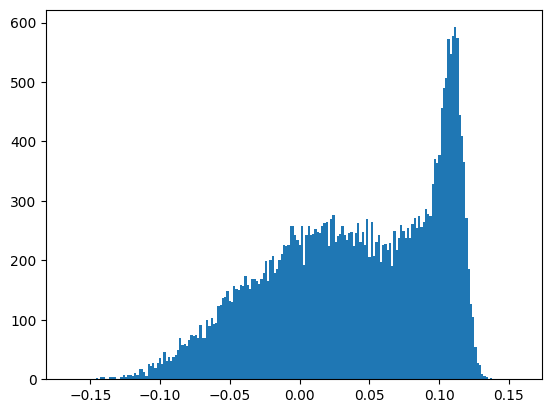

In [8]:
sim = cosine_similarity(word_reprs)
offdiag_mean = (sim.sum(axis=1) - 1) / (sim.shape[0] - 1)
plt.hist(offdiag_mean, bins=200)
offdiag_mean.mean()

In [9]:
wordIdPairs_dict_samplingMethod = {}

far_ids = np.where(offdiag_mean < -0.05)[0]
tokens = tokenizer.convert_ids_to_tokens(far_ids)
wordIdPairs_dict_samplingMethod['far_tokens'] = list(zip(tokens, far_ids))

words = ['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am']
samples = np.random.randint(0, tokenizer.vocab_size, [70])
word_ids = tokenizer.convert_tokens_to_ids(words)
sample_tokens = tokenizer.convert_ids_to_tokens(samples)
words = words + sample_tokens
ids = word_ids + samples.tolist()
wordIdPairs_dict_samplingMethod['random+most_common'] = list(zip(words, ids))
print(words, ids, sep='\n')

sampled_vecs = np.random.rand(150, word_reprs.shape[1])
sampled_args = cosine_similarity(sampled_vecs, word_reprs).argmax(axis=1)
sample_tokens = tokenizer.convert_ids_to_tokens(sampled_args)
wordIdPairs_dict_samplingMethod['random_vectors'] = list(zip(sample_tokens, sampled_args))
print(sample_tokens, sampled_args, sep='\n')

wordIdPairs_dict_samplingMethod['end_with_ed'] = [[key, id_] for key, id_ in tokenizer.vocab.items() if key[-2:] == 'ed']

['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am', 'goldberg', 'boone', 'willem', 'uptown', 'wore', '##nesian', '##kk', 'corresponded', 'fielder', 'glider', 'recordings', '1635', 'clair', 'roadside', 'packages', '##oris', 'geelong', '##ied', 'remix', 'volatile', '##31', '±', 'hunted', 'vulcan', 'chip', '##cie', 'aroused', 'au', 'grasped', 'prove', 'nr', 'sexy', 'encounters', 'west', 'copies', 'sweet', 'usd', '##sities', 'slaughter', 'tractor', 'abby', 'qaeda', 'send', 'councils', 'whispering', 'condemned', 'ethnic', 'narrower', 'yerevan', 'a2', 'captives', 'af', 'fossils', 'differently', '49th', 'energy', 'introduced', '##⁻', 'incapable', '##vy', 'noel', 'shadowed', '##vi', 'generous', '##م', 'besides', 'structures', 'andy', 'gaunt', 'dempsey']
[103, 1010, 1012, 102, 0, 101, 1996, 1998, 1998, 1045, 2014, 2002, 2032, 2016, 2024, 2003, 2027, 1037, 2572, 18522, 15033, 18811, 28539, 5078, 20281, 19658, 27601,

In [ ]:
%%capture --no-stdout --no-display

cmap = plt.get_cmap('rainbow')

def plot_basics(axes, transeds_dict_groupNames, title_prefix=None):
  for ax, (methodName, transeds_dict_groupNames) in zip(axes, transeds_dict_methods_groupNames.items()):
    transeds_dict_groupNames = transeds_dict_groupNames.copy()
    transed_vecs = transeds_dict_groupNames.pop('word')
  
    image = ax.scatter(*transed_vecs.T, marker='.', edgecolors='none', s=3, c=norms, cmap=cmap, alpha=.7, vmin=0)
    fig.colorbar(image, ax=ax, fraction=0.05, pad=0.05)
  
    ax.scatter(*transeds_dict_groupNames['pivot'].T, marker='+', color='red', alpha=.7, label='pivot')
    ax.scatter(*transeds_dict_groupNames['origin'].T, marker='+', color='blue', alpha=.7, label='origin')
    ax.set_title(f"{title_prefix}: {methodName}")
    ax.legend()


fig, axes = plt.subplots(1+len(wordIdPairs_dict_samplingMethod), 2, figsize=[16, 6*(1+len(wordIdPairs_dict_samplingMethod))])

plot_basics(axes[0], transeds_dict_methods_groupNames, 'raw')

for axes_or_a_row, (samplingMethodName, word_id_pairs) in zip(axes[1:], wordIdPairs_dict_samplingMethod.items()):
  plot_basics(axes_or_a_row, transeds_dict_methods_groupNames, samplingMethodName)

  for ax, (ProjectingMethodName, transeds_dict_groupNames) in zip(axes_or_a_row, transeds_dict_methods_groupNames.items()):
    # print(word_id_pairs)
    for word, id_ in word_id_pairs:
      # print(word, id_)
      ax.annotate(word, transeds_dict_groupNames['word'][id_], alpha=.3)

# # fig.savefig(f'image/umap-{subpath}-epoch_{epoch_num}-{batch_num}.png')